# Bioinformatics 575 Group Project


***Lung Cancer Subtypes***

### Task 1 - Load the Data

In [2]:
#install GEOparse to load data set
#pip install GEOparse

In [3]:
#Access lung cancer data
#Link to data file: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE10245

In [4]:
import GEOparse
gse = GEOparse.get_GEO(geo="GSE10245", destdir="./")

05-Dec-2023 14:26:13 DEBUG utils - Directory ./ already exists. Skipping.
05-Dec-2023 14:26:13 INFO GEOparse - File already exist: using local version.
05-Dec-2023 14:26:13 INFO GEOparse - Parsing ./GSE10245_family.soft.gz: 
05-Dec-2023 14:26:13 DEBUG GEOparse - DATABASE: GeoMiame
05-Dec-2023 14:26:13 DEBUG GEOparse - SERIES: GSE10245
05-Dec-2023 14:26:13 DEBUG GEOparse - PLATFORM: GPL570
C:\Users\ajsto\anaconda3\Lib\site-packages\GEOparse\GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")
05-Dec-2023 14:26:14 DEBUG GEOparse - SAMPLE: GSM258551
05-Dec-2023 14:26:14 DEBUG GEOparse - SAMPLE: GSM258552
05-Dec-2023 14:26:14 DEBUG GEOparse - SAMPLE: GSM258553
05-Dec-2023 14:26:14 DEBUG GEOparse - SAMPLE: GSM258554
05-Dec-2023 14:26:14 DEBUG GEOparse - SAMPLE: GSM258555
05-Dec-2023 14:26:14 DEBUG GEOparse - SAMPLE: GSM258556
05-Dec-2023 14:26:14 DEBUG GEOparse - SAMPL

In [5]:
# sklearn.cluster module link: https://scikit-learn.org/stable/modules/clustering.html#k-means
# K-Means Algorithm link: https://www.tutorialspoint.com/machine_learning_with_python/machine_learning_with_python_clustering_algorithms_k_means.htm

In [6]:
import pandas as pd
data = gse.pivot_samples('VALUE')
df = data.T

### Task 2 - Perform clustering via sklearn.cluster module 

C:\Users\ajsto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


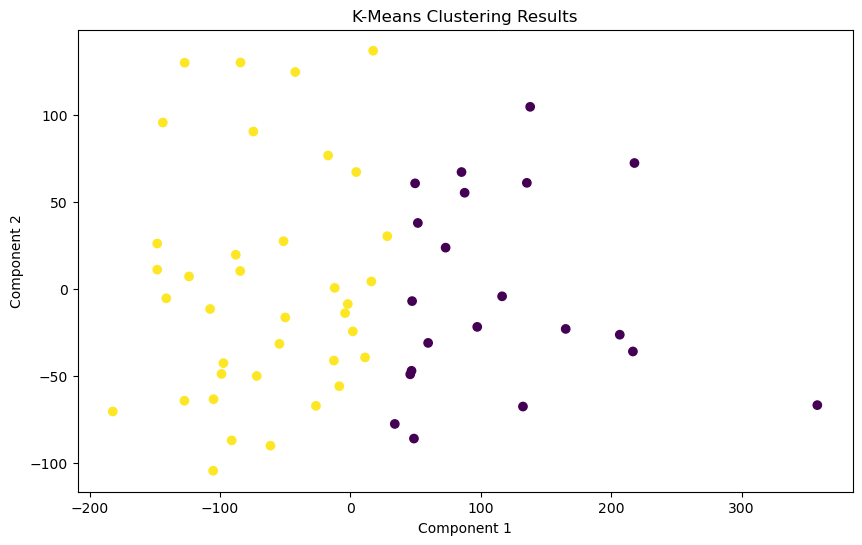

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(df_scaled)

# optional for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_scaled)

plt.figure(figsize=(10, 6))
#plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=cluster_labels, cmap='viridis')
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis')

plt.title("K-Means Clustering Results")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

### Task 3 - Dataframe Creation

In [8]:
df["cluster"] = cluster_labels
subtypes = []
for sample_id, sample in gse.gsms.items():
    #print(sample.metadata)
    subtype_info = sample.metadata.get('characteristics_ch1', [''])[0]
    # Process the subtype_info to extract the actual subtype
    # This might involve string parsing if the information is in a specific format
    subtypes.append([sample_id, subtype_info.replace("disease state: ","")])
subtypes_df = pd.DataFrame(subtypes, columns=['Name', 'Type'])
subtypes_df.set_index('Name', inplace=True)
merge_df = pd.merge(subtypes_df, df, left_index=True, right_index=True)
cluster_df = merge_df[['Type', 'cluster']]
cluster_df.head()

,Type,cluster
Name,,
GSM258551,adenocarcinoma,0
GSM258552,adenocarcinoma,1
GSM258553,squamous cell carcinoma,0
GSM258554,adenocarcinoma,0
GSM258555,squamous cell carcinoma,1


### Task 4 - Compute and display the accuracy of the clustering

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score

cluster_df.loc[:, 'Predicted_Label'] = cluster_df['cluster'].map({1: 'adenocarcinoma', 0: 'squamous cell carcinoma'})
conf_matrix = confusion_matrix(cluster_df['Type'], cluster_df['Predicted_Label'])

accuracy = accuracy_score(cluster_df['Type'], cluster_df['Predicted_Label'])
#print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)

Accuracy: 0.5344827586206896


C:\Users\ajsto\AppData\Local\Temp\ipykernel_1548\1752634035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df.loc[:, 'Predicted_Label'] = cluster_df['cluster'].map({1: 'adenocarcinoma', 0: 'squamous cell carcinoma'})


### Task 5 - Fit the model on half of the data predict the cluster for the other half

In [10]:


from sklearn.model_selection import train_test_split

# get original data of df in question 1
expression_df = df.drop(columns=["cluster"])
subtype_df = subtypes_df

# Merging the expression data with subtype information
merged_df = pd.merge(expression_df, subtype_df, left_on='name', right_on='Name')

# Splitting the data into adenocarcinoma (AD) and squamous cell carcinoma (SCC)
ad_df = merged_df[merged_df["Type"] == "adenocarcinoma"]
scc_df = merged_df[merged_df["Type"] == "squamous cell carcinoma"]

# Splitting each subtype into two halves for training and testing
ad_train, ad_test = train_test_split(ad_df, test_size=0.5, random_state=42)
scc_train, scc_test = train_test_split(scc_df, test_size=0.5, random_state=42)

# Combining the halves to create training and testing datasets
train_df = pd.concat([ad_train, scc_train])
test_df = pd.concat([ad_test, scc_test])

# DataFrame containing training data, excluding the "Type" column
X_train = train_df.drop(columns=["Type"])

# Training the KMeans model on the first half of the data
kmeans_train = KMeans(n_clusters=2, n_init=10, random_state=42)
kmeans_train.fit(X_train)

# Preparing the test data (features only)
X_test = test_df.drop(columns=["Type"])

# Predicting the cluster labels for the second half
test_cluster_labels = kmeans_train.predict(X_test)



C:\Users\ajsto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Task 6 - Compute and display the accuracy of the model for the prediction results

In [11]:

# Mapping cluster numbers to subtype labels. Just like question 4
train_df['cluster'] = kmeans_train.labels_

# Finding the most common subtype for each cluster
cluster_0_subtype = train_df[train_df['cluster'] == 0]['Type'].mode()[0] 
cluster_1_subtype = train_df[train_df['cluster'] == 1]['Type'].mode()[0]

# Mapping cluster numbers to subtype labels for the test data
test_predicted_labels = pd.Series(test_cluster_labels).map({0: cluster_0_subtype, 1: cluster_1_subtype})

# Evaluating the performance on the test data. Just like question 4
test_accuracy = accuracy_score(test_df["Type"], test_predicted_labels)

print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9655172413793104


### Part 7 - Plot (bar plot) the 3 accuracy values for the model

In [12]:
# (i) train the model on all the data and compute the accuracy of the model on that data
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

X_all = merged_df.drop(columns=["Type"])

kmeans_all = KMeans(n_clusters=2, n_init=10, random_state=42)
#Kmeans analysis
kmeans_all.fit(X_all)
#Assign cluster labels
merged_df['cluster'] = kmeans_all.labels_

#Find most common subtype - see part 5 
cluster_0_subtype_all = merged_df[merged_df['cluster'] == 0]['Type'].mode()[0]
cluster_1_subtype_all = merged_df[merged_df['cluster'] == 1]['Type'].mode()[0]

#Cluster labels from KMeans model mapped to predicted subtypes
all_predicted_labels = pd.Series(kmeans_all.labels_).map({0: cluster_0_subtype_all, 1: cluster_1_subtype_all})

#Compute accuracy
accuracy_all = accuracy_score(merged_df["Type"], all_predicted_labels)
print("Accuracy on All Data:", accuracy_all)

# (ii) train the model on half of the data and compute the accuracy of the model on that data

df_task7, _ = train_test_split(merged_df, test_size=0.5, random_state=42)
X_train_task7 = df_task7.drop(columns=["Type"])

kmeans_train_task7 = KMeans(n_clusters=2, n_init=10, random_state=42)
kmeans_train_task7.fit(X_train_task7)

train_cluster_task7 = kmeans_train_task7.predict(X_train_task7)
train_df_task7 = df_task7.copy()
train_df_task7['cluster'] = kmeans_train_task7.labels_

cluster_0_subtype_task7 = train_df_task7[train_df_task7['cluster'] == 0]['Type'].mode()[0]
cluster_1_subtype_task7 = train_df_task7[train_df_task7['cluster'] == 1]['Type'].mode()[0]

predicted_labels_task7 = pd.Series(train_cluster_task7).map({0: cluster_0_subtype_task7, 1: cluster_1_subtype_task7})

accuracy_task7 = accuracy_score(train_df_task7["Type"], predicted_labels_task7)
print("Accuracy on Half of the Data:", accuracy_task7)

C:\Users\ajsto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Accuracy on All Data: 0.8793103448275862


C:\Users\ajsto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Accuracy on Half of the Data: 0.8620689655172413


In [13]:
# (iii) compute the model accuracy built at point (ii) on the other half of the data (test data)

#Get remaining half of data set

test_df_task7 = merged_df.drop(df_task7.index)

#Get features 
X_test_task7 = test_df_task7.drop(columns=['Type'])

#Utilize trained model from i&ii to predict labels for test data (essentially the same from part ii but with 'test' data)
test_cluster_task7 = kmeans_train_task7.predict(X_test_task7)
test_df_task7 = test_df_task7.copy() #Avoid motifying original datafram directly
test_df_task7['cluster'] = test_cluster_task7 #predicted labels added as new column

#Map cluster labels to subtype labels 

cluster_0_subtype_test_task7 = test_df_task7[test_df_task7['cluster'] == 0]['Type'].mode()[0]
cluster_1_subtype_test_task7 = test_df_task7[test_df_task7['cluster'] == 1]['Type'].mode()[0]

#Assign predicted cluster labels to subtype labels

predicted_labels_test_task7 = pd.Series(test_cluster_task7).map({
    0: cluster_0_subtype_test_task7, 
    1: cluster_1_subtype_test_task7
})

#Compute accuracy 
accuracy_test_task7 = accuracy_score(test_df_task7["Type"], predicted_labels_test_task7)
print("Accuracy on the Other Half of the Data (Test Data):", accuracy_test_task7)

Accuracy on the Other Half of the Data (Test Data): 0.896551724137931


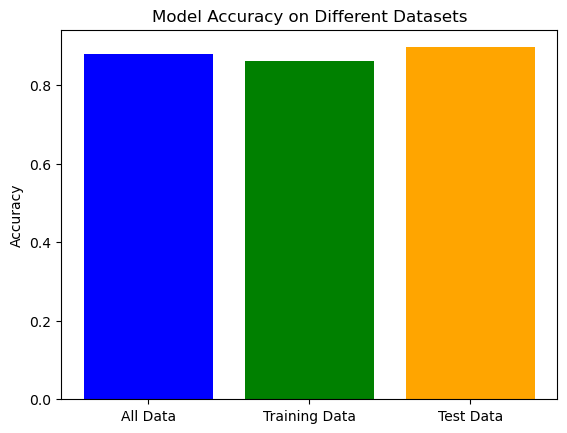

In [14]:
#Plot accuracies 
accuracies = [accuracy_all, accuracy_task7, accuracy_test_task7]
labels = ['All Data', 'Training Data', 'Test Data']

plt.bar(labels, accuracies, color=['blue', 'green', 'orange'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy on Different Datasets')
plt.show()

### Task 8 - What are the top differentailly expressed genes in two types of tumor from the dataset?

In [15]:
# data breakdown
# seperate the data into 2 dataframe without removing any information, each of them represent one type of tumor group


# merge original df in question 1 with type column
df_with_type = pd.merge(subtypes_df, df, left_index=True, right_index=True)
df_with_type = df_with_type.drop('cluster', axis=1)

# Splitting the data into adenocarcinoma (AD) and squamous cell carcinoma (SCC)
ad_df_type = df_with_type[df_with_type["Type"] == "adenocarcinoma"]
scc_df_type = df_with_type[df_with_type["Type"] == "squamous cell carcinoma"]

print('AD type: \n', ad_df_type.head(10), '\n')
print('SCC type:', scc_df_type.head(3))

AD type: 
                      Type  1007_s_at   1053_at    117_at    121_at  1255_g_at  \
Name                                                                            
GSM258551  adenocarcinoma   9.129905  8.034022  3.564520  4.746490   2.320698   
GSM258552  adenocarcinoma   9.843349  7.973332  4.994852  5.197306   2.248520   
GSM258554  adenocarcinoma   9.032165  7.723965  4.958580  6.078180   2.262787   
GSM258558  adenocarcinoma   8.881805  7.575620  4.659326  5.362637   2.255955   
GSM258559  adenocarcinoma   9.039005  8.438594  6.643723  5.210988   2.266399   
GSM258560  adenocarcinoma  10.643545  9.142260  5.368356  5.195820   2.246563   
GSM258561  adenocarcinoma   8.475739  7.059735  5.232265  5.201818   2.262974   
GSM258564  adenocarcinoma   8.579661  8.207932  4.681478  5.231288   2.239315   
GSM258567  adenocarcinoma   8.861207  8.807377  6.643963  5.189461   2.849022   
GSM258568  adenocarcinoma   9.977437  8.568888  4.798631  5.953555   2.239398   

            1294

In [16]:
# Calculate mean expression levels for each gene in both groups
scc_df_type =scc_df_type.drop('Type', axis=1)
ad_df_type  =ad_df_type.drop('Type', axis=1)
ad_mean = ad_df_type.mean()
scc_mean = scc_df_type.mean()

# Calculate fold change (SCC/AD)
fold_change = scc_mean / ad_mean
fold_change

1007_s_at               1.059771
1053_at                 1.067481
117_at                  0.992334
121_at                  0.993507
1255_g_at               1.072775
                          ...   
AFFX-r2-Ec-bioC-5_at    0.985187
AFFX-r2-Ec-bioD-3_at    0.990181
AFFX-r2-Ec-bioD-5_at    0.993273
AFFX-r2-P1-cre-3_at     0.997063
AFFX-r2-P1-cre-5_at     0.995460
Length: 54675, dtype: float64

In [17]:
import scipy.stats as stats
import numpy as np

# Perform t-tests for each gene
p_values = [stats.ttest_ind(ad_df_type[gene], scc_df_type[gene], nan_policy='omit').pvalue for gene in ad_df_type.columns]

# Adjust p-values for multiple comparisons (FDR)
from statsmodels.stats.multitest import multipletests
_, p_adjusted, _, _ = multipletests(p_values, method='fdr_bh')

# Combine results into a DataFrame
results_df = pd.DataFrame({
    'Probe ID': ad_df_type.columns,
    'Fold Change': fold_change,
    'Adjusted P-Value': p_adjusted
})



In [18]:
#To convert probe ID into gene symbol
#Dowload family file and extract probe ID-gene symbol information
import requests
import gzip
import tarfile
import pandas as pd
from io import BytesIO

# Download the file in chunks
url = 'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE10nnn/GSE10245/miniml/GSE10245_family.xml.tgz'
with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with open('GSE10245_family.xml.tgz', 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

# Unzip the .tgz file
with gzip.open('GSE10245_family.xml.tgz') as f:
    with tarfile.open(fileobj=f) as tar:
        tar.extractall("extracted_files")
file_path = 'extracted_files/GPL570-tbl-1.txt'  # Adjust the path
df_mapping = pd.read_csv(file_path, sep='\t', usecols=[0, 10])
df_mapping.columns = ['Probe ID', 'Gene Symbol']
df_mapping.dropna(subset=['Probe ID', 'Gene Symbol'], inplace=True)

In [19]:
#To annotate gene and get top 50 high/low expression gene
merged_df = pd.merge(results_df, df_mapping, how='left', left_on='Probe ID', right_on='Probe ID')
High_express50 = merged_df.sort_values(by='Fold Change', ascending=False).head(50)
Low_express50 = merged_df.sort_values(by='Fold Change', ascending=True).head(50)

In [20]:
High_express50

,Probe ID,Fold Change,Adjusted P-Value,Gene Symbol
15611,206165_s_at,4.093878,9.612255e-12,CLCA2
11268,201820_at,3.645914,8.126396e-11,KRT5
41336,232082_x_at,3.476228,1.247257e-08,SPRR3
26557,217272_s_at,3.412262,4.606454e-09,SERPINB13
15612,206166_s_at,3.391912,1.827222e-12,CLCA2
17371,207935_s_at,3.327384,2.653904e-08,KRT13
15480,206033_s_at,3.323490,5.884200e-14,DSC3
44324,235075_at,3.302057,6.760476e-10,DSG3
23096,213796_at,3.283869,8.289706e-08,SPRR1A
15042,205595_at,3.273257,6.760476e-10,DSG3


In [21]:
Low_express50

,Probe ID,Fold Change,Adjusted P-Value,Gene Symbol
16200,206754_s_at,0.442469,4.475015e-05,CYP2B6 /// CYP2B7P
38284,229030_at,0.450836,3.250906e-08,CAPN8
31008,221728_x_at,0.453420,4.697510e-02,XIST
33847,224588_at,0.459131,5.022415e-02,XIST
38626,229372_at,0.459731,3.093836e-07,GOLT1A
29677,220393_at,0.461413,8.105681e-05,LGSN
14668,205221_at,0.465841,2.692952e-03,HGD
36925,227671_at,0.467498,5.109029e-02,XIST
15341,205894_at,0.477712,8.749450e-04,ARSE
45679,236430_at,0.484323,2.511086e-03,TMED6


In [22]:
#Visualization using seaborn library 
#pip install seaborn matplotlib

In [23]:
top_10_genes = High_express50.head(10)

In [24]:
top_10_genes

,Probe ID,Fold Change,Adjusted P-Value,Gene Symbol
15611,206165_s_at,4.093878,9.612255e-12,CLCA2
11268,201820_at,3.645914,8.126396e-11,KRT5
41336,232082_x_at,3.476228,1.247257e-08,SPRR3
26557,217272_s_at,3.412262,4.606454e-09,SERPINB13
15612,206166_s_at,3.391912,1.827222e-12,CLCA2
17371,207935_s_at,3.327384,2.653904e-08,KRT13
15480,206033_s_at,3.323490,5.884200e-14,DSC3
44324,235075_at,3.302057,6.760476e-10,DSG3
23096,213796_at,3.283869,8.289706e-08,SPRR1A
15042,205595_at,3.273257,6.760476e-10,DSG3


In [25]:
#import necessary packages 

import seaborn as sns 
import matplotlib.pyplot as plt

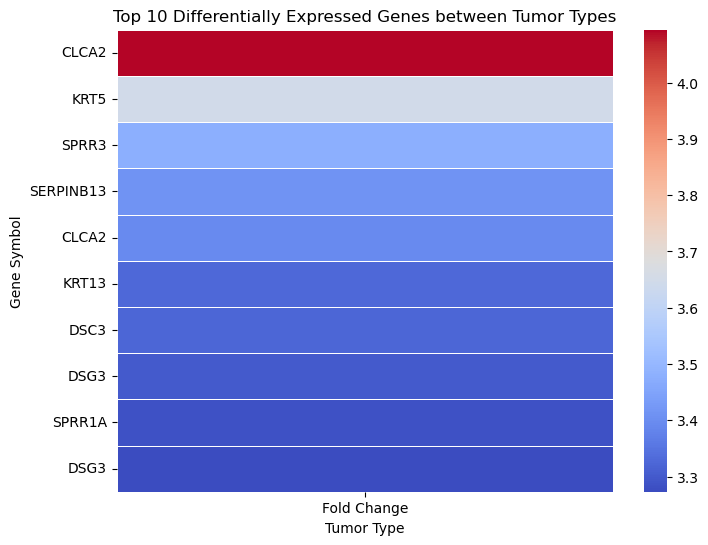

In [26]:
# Create a heatmap for the top 10 genes without annotations

plt.figure(figsize=(8, 6))
sns.heatmap(top_10_genes.set_index('Gene Symbol')[['Fold Change']], cmap='coolwarm', linewidths=.5, annot=False)

# Label the x-axis with 'Tumor Type'
plt.xlabel('Tumor Type')

# Label the y-axis with 'Gene Symbol'
plt.ylabel('Gene Symbol')

# Set the title
plt.title('Top 10 Differentially Expressed Genes between Tumor Types')

plt.show()

#Interpretation: AC = condition 1, SCC = condition 2. Fold change SCC/AD. Smaller numbers = more common in AD, larger = more common in SCC

In [27]:
bottom_10_genes = Low_express50.head(10)

In [28]:
bottom_10_genes

,Probe ID,Fold Change,Adjusted P-Value,Gene Symbol
16200,206754_s_at,0.442469,4.475015e-05,CYP2B6 /// CYP2B7P
38284,229030_at,0.450836,3.250906e-08,CAPN8
31008,221728_x_at,0.453420,4.697510e-02,XIST
33847,224588_at,0.459131,5.022415e-02,XIST
38626,229372_at,0.459731,3.093836e-07,GOLT1A
29677,220393_at,0.461413,8.105681e-05,LGSN
14668,205221_at,0.465841,2.692952e-03,HGD
36925,227671_at,0.467498,5.109029e-02,XIST
15341,205894_at,0.477712,8.749450e-04,ARSE
45679,236430_at,0.484323,2.511086e-03,TMED6


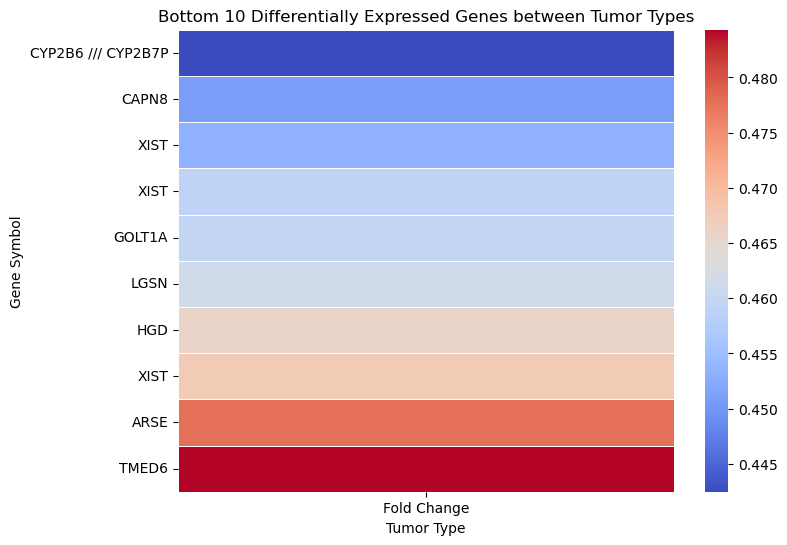

In [29]:
plt.figure(figsize=(8, 6))
sns.heatmap(bottom_10_genes.set_index('Gene Symbol')[['Fold Change']], cmap='coolwarm', linewidths=.5, annot=False)

# Label the x-axis with 'Tumor Type'
plt.xlabel('Tumor Type')

# Label the y-axis with 'Gene Symbol'
plt.ylabel('Gene Symbol')

# Set the title
plt.title('Bottom 10 Differentially Expressed Genes between Tumor Types')

plt.show()

In [30]:
# pip install goatools
import goatools

In [31]:
from goatools.go_enrichment import GOEnrichmentStudy
from goatools.obo_parser import GODag
from goatools.associations import read_ncbi_gene2go
import requests
# URL for the GO Basic OBO file
obo_url = "http://geneontology.org/ontology/go-basic.obo"

# Download the OBO file
response = requests.get(obo_url)

if response.status_code == 200:
    with open("go-basic.obo", "wb") as f:
        f.write(response.content)
    print("Download successful. OBO file saved as 'go-basic.obo'")
else:
    print(f"Failed")

Download successful. OBO file saved as 'go-basic.obo'


In [32]:
from goatools.base import download_ncbi_associations
# fin -> Filename of input file (file to be read)
fin_gene2go = download_ncbi_associations()

  EXISTS: gene2go


In [33]:
from goatools.anno.genetogo_reader import Gene2GoReader
gene2go_reader = Gene2GoReader(fin_gene2go, taxids=[9606])

HMS:0:00:43.835990 345,232 annotations, 20,762 genes, 18,774 GOs, 1 taxids READ: gene2go 


In [34]:
#Intialize GODag
obo_dag = GODag('go-basic.obo')

go-basic.obo: fmt(1.2) rel(2023-11-15) 46,228 Terms


In [35]:
#Added optional attribute godag=obo_dag
    # (allows you to provide the Gene Ontology DAG to the Gene2GoReader.
    #It is used to associate the GO terms in the annotation file with the hierarchical structure of the Gene Ontology.)

In [36]:
gene2go_reader = Gene2GoReader(fin_gene2go, taxids=[9606], godag=obo_dag)

HMS:0:00:43.331724 345,232 annotations, 20,762 genes, 18,774 GOs, 1 taxids READ: gene2go 


In [37]:
# this method processes the Gene2Go annotation file
#(fin_gene2go) and returns a dictionary (gene2go) that maps gene identifiers to sets of associated GO terms.

In [38]:
gene2go = gene2go_reader.get_id2gos()

20723 IDs in loaded association branch, biological_process


In [39]:
print(High_express50.head())
print(Low_express50.head())

          Probe ID  Fold Change  Adjusted P-Value Gene Symbol
15611  206165_s_at     4.093878      9.612255e-12       CLCA2
11268    201820_at     3.645914      8.126396e-11        KRT5
41336  232082_x_at     3.476228      1.247257e-08       SPRR3
26557  217272_s_at     3.412262      4.606454e-09   SERPINB13
15612  206166_s_at     3.391912      1.827222e-12       CLCA2
          Probe ID  Fold Change  Adjusted P-Value         Gene Symbol
16200  206754_s_at     0.442469      4.475015e-05  CYP2B6 /// CYP2B7P
38284    229030_at     0.450836      3.250906e-08               CAPN8
31008  221728_x_at     0.453420      4.697510e-02                XIST
33847    224588_at     0.459131      5.022415e-02                XIST
38626    229372_at     0.459731      3.093836e-07              GOLT1A


In [40]:
# Converting gene symbols in our gene set into entrezID used in gene2go for mapping
# pip install mygene
# Top 50 highly expressed genes:
import mygene

conversion_High_express50 = High_express50['Gene Symbol'].tolist()
mg = mygene.MyGeneInfo()
out_High_express50 = mg.querymany(conversion_High_express50, scopes='symbol', fields='entrezgene', species='human')
High_express50_dict = {}

for item in out_High_express50:
    if 'notfound' in item and item['notfound']:
        continue
    query = item['query']    
    if 'entrezgene' in item:
        entrezgene = item['entrezgene']
        formatted_entrezgene = f"GO:{int(entrezgene):07d}"
        High_express50_dict[query] = formatted_entrezgene

print(High_express50_dict)


# Top 50 lowly expressed genes:
conversion_Low_express50 = Low_express50['Gene Symbol'].tolist()
mg = mygene.MyGeneInfo()
out_Low_express50 = mg.querymany(conversion_Low_express50, scopes='symbol', fields='entrezgene', species='human')
Low_express50_dict = {}

for item in out_Low_express50:
    if 'notfound' in item and item['notfound']:
        continue
    query = item['query']    
    if 'entrezgene' in item:
        entrezgene = item['entrezgene']
        formatted_entrezgene = f"GO:{int(entrezgene):07d}"
        Low_express50_dict[query] = formatted_entrezgene

print(Low_express50_dict)


ModuleNotFoundError: No module named 'mygene'

In [ ]:
# Downloaded go-basic.obo file
obo_file = "Desktop/BIOINF 575/BIOINF-575-Project-main/go-basic.obo"

# Load Gene Ontology (GO) DAG
obo_dag = GODag("go-basic.obo")

# Perform GO enrichment analysis for top 50 highly expressed genes
goeaobj_top = GOEnrichmentStudy(
    High_express50_dict,
    gene2go,
    obo_dag,
    study_id="High_express50",
    alpha=0.05,
    methods=["fdr_bh"]
)

goea_results_top = goeaobj_top.run_study(study=High_express50)

# Perform GO enrichment analysis for bottom 50 lowly expressed genes
goeaobj_bottom = GOEnrichmentStudy(
    Low_express50_dict,
    gene2go,
    obo_dag,
    study_id="Low_express50",
    alpha=0.05,
    methods=["fdr_bh"]
)

goea_results_bottom = goeaobj_bottom.run_study(study=Low_express50)
#goea_results_top = goeaobj_top.run_study()
#goea_results_bottom = goeaobj_bottom.run_study()

In [ ]:
# Converting gene symbols in our gene set into entrezID used in gene2go for mapping
# Top 10 highly expressed genes:
import mygene

conversion_top_10_genes = top_10_genes['Gene Symbol'].tolist()
mg = mygene.MyGeneInfo()
out_top_10 = mg.querymany(conversion_top_10_genes, scopes='symbol', fields='entrezgene', species='human')
top_10_genes_dict = {}

for item in out_top_10:
    query = item['query']
    entrezgene_top = item['entrezgene']
    
    # Format entrezgene to have 7 digits
    formatted_entrezgene = f"GO:{int(entrezgene):07d}"
    
    top_10_genes_dict[query] = formatted_entrezgene

print(top_10_genes_dict)

In [ ]:
# Top 10 lowly expressed genes:
conversion_bottom_10_genes = bottom_10_genes['Gene Symbol'].tolist()
mg = mygene.MyGeneInfo()
out_bottom_10 = mg.querymany(conversion_bottom_10_genes, scopes='symbol', fields='entrezgene', species='human')
bottom_10_geness_dict = {}
for item in out_bottom_10:
    if 'notfound' in item and item['notfound']:
        continue
    query = item['query']    
    if 'entrezgene' in item:
        entrezgene = item['entrezgene']
        formatted_entrezgene = f"GO:{int(entrezgene):07d}"
        bottom_10_geness_dict[query] = formatted_entrezgene

print(bottom_10_geness_dict)

In [ ]:
# Perform GO enrichment analysis for top 10 highly expressed genes
goeaobj_top = GOEnrichmentStudy(
    top_10_genes_dict,
    gene2go,
    obo_dag,
    study_id="top_10_genes",
    alpha=0.05,
    methods=["fdr_bh"]
)

goea_results_top = goeaobj_top.run_study(study=top_10_genes)

# Perform GO enrichment analysis for top 10 lowly expressed genes
goeaobj_bottom = GOEnrichmentStudy(
    bottom_10_geness_dict,
    gene2go,
    obo_dag,
    study_id="bottom_10_genes",
    alpha=0.05,
    methods=["fdr_bh"]
)

goea_results_bottom = goeaobj_bottom.run_study(study=bottom_10_genes)

## Volcano Plot for Visualization

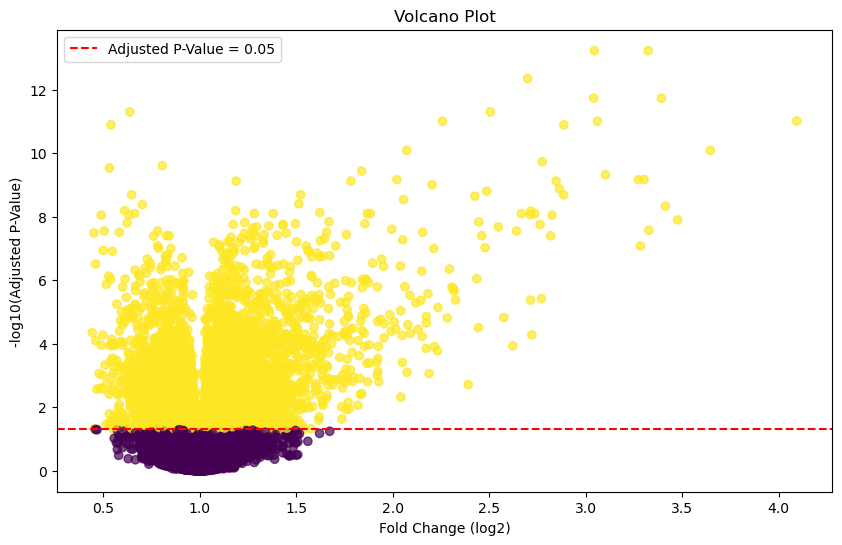

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Set the significance threshold
alpha = 0.05

# Create a boolean mask for significant genes based on adjusted p-value, basically used to color the points based on where they fall
significant_genes = merged_df['Adjusted P-Value'] < alpha

# Plot volcano plot

#Set figure size
plt.figure(figsize=(10, 6))

#Use Fold Change to make X axis and Adjusted P values to make Y axis, logs used to visualize the small P values
plt.scatter(merged_df['Fold Change'], -np.log10(merged_df['Adjusted P-Value']), c=significant_genes, cmap='viridis', alpha=0.7)

#Add titles and set colors
plt.title('Volcano Plot')
plt.xlabel('Fold Change (log2)')
plt.ylabel('-log10(Adjusted P-Value)')
plt.axhline(-np.log10(alpha), color='red', linestyle='--', label=f'Adjusted P-Value = {alpha}')
plt.legend()
plt.show()

In [ ]:
#Volcano plot interpretation: 

    # Each point represents a gene and x-axis position indicates how much the gene's expression changes between conditions
    #Y axis is adjusted P-value 
    #Statistically significant gnes are higher up on Y axis (Yellow is significant)
    # Points in upper corners are both significantly changed and have a substantial fold change 
        # Right of center is upregulation and left is down regulation. 
            # fold_change = scc_mean / ad_mean
    
    #There are clearly a wide distribution of scc genes that are upregulated. These could be of interest for future investigations. 